Saving heart_selected_features_final.csv to heart_selected_features_final (1).csv
Dataset shape: (229, 5)
Class distribution:
 target
1    133
0     96
Name: count, dtype: int64
Training samples: 183
Testing samples: 46

=== Neural Network Hyperparameter Tuning ===
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters for Neural Network: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
Best CV Score (F1): 0.8555805877400562

=== Neural Network Performance (Test Set) ===
Accuracy: 0.782608695652174
Precision: 0.7741935483870968
Recall: 0.8888888888888888
F1 Score: 0.8275862068965517
ROC AUC: 0.7894736842105263

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.80      0.63      0.71        19
     Disease       0.77      0.89      0.83        27

    accuracy                           0.78        46
   macro avg       0.79      0.76      0.77        46
weighted a

<Figure size 800x600 with 0 Axes>

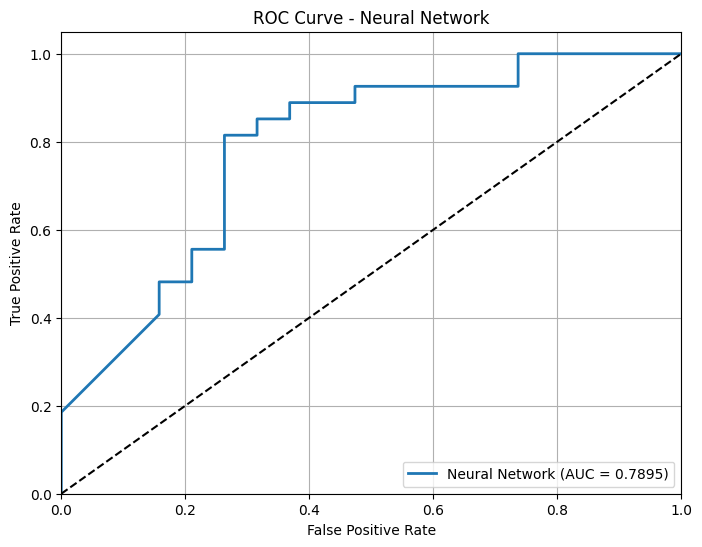

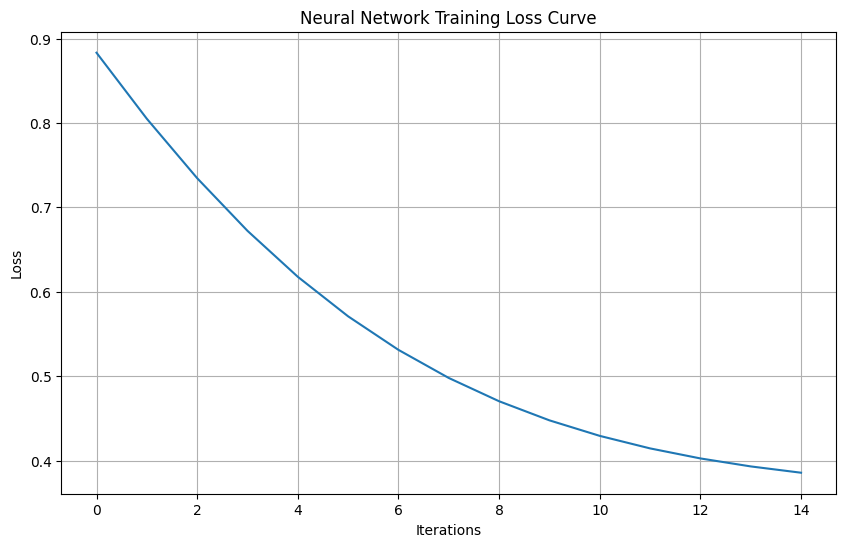


=== Proper Cross-Validation ===
Neural Network CV F1 Scores: [0.7391 0.7111 0.9302 0.766  0.8889]
Neural Network Mean CV F1: 0.8071 +/- 0.1729

Overfitting Analysis:
Train Accuracy: 0.7213
Test Accuracy:  0.7826
Accuracy Gap:   0.0613
--- POTENTIAL OVERFITTING ---

Neural Network Architecture:
Input features: 5
Hidden layers: (100, 50)
Output: 1 (binary classification)
Total iterations: 15

✓ Neural Network model saved as 'neural_network_model.pkl'
✓ Scaler saved as 'nn_scaler.pkl'


In [3]:


# IT24102496 - Neural Network Model
from google.colab import files
uploaded = files.upload()

# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                           classification_report, roc_curve)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Loading the preprocessed dataset
df = pd.read_csv("heart_selected_features_final.csv")

# Preparing features and target
X = df.drop("target", axis=1)
y = df["target"]

print("Dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts())

# Scale features for Neural Network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Define consistent CV strategy
CV_STRATEGY = 5
cv = StratifiedKFold(n_splits=CV_STRATEGY, shuffle=True, random_state=42)

# Hyperparameter tuning for Neural Network
print("\n=== Neural Network Hyperparameter Tuning ===")
param_grid_nn = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "activation": ['relu', 'tanh', 'logistic'],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ['constant', 'adaptive']
}

grid_nn = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
    param_grid=param_grid_nn,
    scoring="f1",
    cv=CV_STRATEGY,
    n_jobs=-1,
    verbose=1
)

grid_nn.fit(X_train, y_train)
print("Best Parameters for Neural Network:", grid_nn.best_params_)
print("Best CV Score (F1):", grid_nn.best_score_)

# Getting the tuned model
nn_model = grid_nn.best_estimator_

# Test set evaluation
y_pred_nn = nn_model.predict(X_test)
y_proba_nn = nn_model.predict_proba(X_test)[:, 1]

print("\n=== Neural Network Performance (Test Set) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1 Score:", f1_score(y_test, y_pred_nn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Disease', 'Disease']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nn),
                       display_labels=['No Disease', 'Disease']).plot(cmap="Blues")
plt.title("Neural Network Confusion Matrix (Tuned)")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr, tpr, linewidth=2, label=f"Neural Network (AUC = {roc_auc_score(y_test, y_proba_nn):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Training history (if available)
if hasattr(nn_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn_model.loss_curve_)
    plt.title('Neural Network Training Loss Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Proper Cross-Validation
print("\n=== Proper Cross-Validation ===")
nn_fresh = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, **grid_nn.best_params_)
nn_cv_scores = cross_val_score(nn_fresh, X_train, y_train, cv=cv, scoring="f1")

print("Neural Network CV F1 Scores:", nn_cv_scores.round(4))
print("Neural Network Mean CV F1:", nn_cv_scores.mean().round(4), "+/-", (nn_cv_scores.std() * 2).round(4))

# Overfitting analysis
train_pred = nn_model.predict(X_train)
test_pred = y_pred_nn

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
accuracy_gap = abs(train_accuracy - test_accuracy)

print(f"\nOverfitting Analysis:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Accuracy Gap:   {accuracy_gap:.4f}")

if accuracy_gap > 0.05:
    print("--- POTENTIAL OVERFITTING ---")
else:
    print("--- GOOD GENERALIZATION ---")

# Network architecture info
print(f"\nNeural Network Architecture:")
print(f"Input features: {X.shape[1]}")
print(f"Hidden layers: {nn_model.hidden_layer_sizes}")
print(f"Output: 1 (binary classification)")
print(f"Total iterations: {nn_model.n_iter_}")

# Save the model and scaler
import joblib
joblib.dump(nn_model, 'neural_network_model.pkl')
joblib.dump(scaler, 'nn_scaler.pkl')
print("\n✓ Neural Network model saved as 'neural_network_model.pkl'")
print("✓ Scaler saved as 'nn_scaler.pkl'")